# 目录
1. [数据读取与章节整合整合](#1.数据读取与整合) 
2. [剧情趋势和人物词频分析](#2.剧情趋势和人物词频分析)  
3. [红楼梦章节聚类及可视化](#3.红楼梦章节聚类及可视化)
7. [总结](#7.总结)

<div id="1"></div>
# 1.数据读取与整合

In [1]:
## 加载数据包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
import nltk

数据集介绍如下：
+ `Dream_of_the_Red_Mansion.txt`为红楼梦小说的txt版本，编码格式为utf-8。
+ `Red_Mansion_Dictionary.txt`为包含红楼梦中专有人物的词典，用于辅助分词。
+ `stop_words.txt`为停用词表，包含数字、特殊符号等常见的停用词。

In [2]:
## 设置显示偏好
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",None)

## 读取文章、停用词和需要的词典
stop_words = pd.read_csv("./input/stop_words.txt",header=None,names = ["stop_words"])
dictionary = pd.read_csv("./input/Red_Mansion_Dictionary.txt",header=None, names=["dictionary"])
content = pd.read_csv("./input/Dream_of_the_Red_Mansion.txt",header=None,names = ["content"])

print(content.head(),'\n\n',dictionary.head(),'\n\n',stop_words.head())

                                             content
0                                                第1卷
1                              第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
2  　　此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<...
3                 　　此回中凡用“梦”用“幻”等字，是提醒阅者眼目，亦是此书立意本旨。
4  　　列位看官：你道此书从何而来？说起根由虽近荒唐，细按则深有趣味。待在下将此来历注明，方使阅... 

   dictionary
0         黛玉
1         宝钗
2         贾演
3         贾寅
4         贾源 

   stop_words
0          $
1          0
2          1
3          2
4          3


接下来我们需要对文本数据进行预处理，整合显示格式。首先需要分析的是读取的数据是否存在缺失值，可以使用Pandas中的`isnull()`函数进行判断。

In [3]:
## 查看文章是否有空白的行，如有则删除
np.sum(pd.isnull(content))  

content    0
dtype: int64

为了观察的美观和简便，我们删除`第1卷`、`第2卷`等文字占用的行，使用正则表达式进行匹配，将满足条件的索引进行筛选。

In [4]:
## 使用正则表达式，选取相应索引
index_of_juan = content.content.str.contains("^第+.+卷") 

## 根据索引删除不需要的行，并重新设置索引
content = content[~index_of_juan].reset_index(drop=True) 
content.head()

content
0                              第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
1  　　此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<...
2                 　　此回中凡用“梦”用“幻”等字，是提醒阅者眼目，亦是此书立意本旨。
3  　　列位看官：你道此书从何而来？说起根由虽近荒唐，细按则深有趣味。待在下将此来历注明，方使阅...
4  　　原来女娲氏炼石补天之时，于大荒山无稽崖练成高经十二丈，方经二十四丈顽石三万六千五百零一块...

接下来我们提取每个章节的标题，并进行字符的处理。

In [5]:
## 使用正则表达式，选取相应索引
index_of_hui = content.content.str.match("^第+.+回")

## 根据索引选取每一章节的标题
chapter_names = content.content[index_of_hui].reset_index(drop=True)
chapter_names.head()

0    第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
1    第二回 贾夫人仙逝扬州城 冷子兴演说荣国府
2    第三回 贾雨村夤缘复旧职 林黛玉抛父进京都
3    第四回 薄命女偏逢薄命郎 葫芦僧乱判葫芦案
4    第五回 游幻境指迷十二钗 饮仙醪曲演红楼梦
Name: content, dtype: object

In [6]:
## 处理章节名，按照空格分割字符串
chapter_names_split = chapter_names.str.split(" ").reset_index(drop=True)
chapter_names_split.head()

0    [第一回, 甄士隐梦幻识通灵, 贾雨村风尘怀闺秀]
1    [第二回, 贾夫人仙逝扬州城, 冷子兴演说荣国府]
2    [第三回, 贾雨村夤缘复旧职, 林黛玉抛父进京都]
3    [第四回, 薄命女偏逢薄命郎, 葫芦僧乱判葫芦案]
4    [第五回, 游幻境指迷十二钗, 饮仙醪曲演红楼梦]
Name: content, dtype: object

处理好章节标题后，接着我们计算每一章含有多少行、多少字，同时将每章节的内容进行整合，形成一个新的DataFrame对象。

In [7]:
## 建立保存数据的数据框
data = pd.DataFrame(list(chapter_names_split),columns=["chapter","left_name","right_name"])

## 添加章节序号和章节名称列
data["chapter_number"] = np.arange(1,121)
data["chapter_name"] = data.left_name+","+data.right_name

## 添加每章开始的行位置
data["start_id"] = index_of_hui[index_of_hui == True].index

## 添加每章结束的行位置
data["end_id"] = data["start_id"][1:len(data["start_id"])].reset_index(drop = True) - 1
data["end_id"][[len(data["end_id"])-1]] = content.index[-1]

## 添加每章的行数
data["length_of_chapters"] = data.end_id - data.start_id

data.head()

chapter left_name right_name  chapter_number       chapter_name  start_id  \
0     第一回  甄士隐梦幻识通灵   贾雨村风尘怀闺秀               1  甄士隐梦幻识通灵,贾雨村风尘怀闺秀         0   
1     第二回  贾夫人仙逝扬州城   冷子兴演说荣国府               2  贾夫人仙逝扬州城,冷子兴演说荣国府        50   
2     第三回  贾雨村夤缘复旧职   林黛玉抛父进京都               3  贾雨村夤缘复旧职,林黛玉抛父进京都        80   
3     第四回  薄命女偏逢薄命郎   葫芦僧乱判葫芦案               4  薄命女偏逢薄命郎,葫芦僧乱判葫芦案       119   
4     第五回  游幻境指迷十二钗   饮仙醪曲演红楼梦               5  游幻境指迷十二钗,饮仙醪曲演红楼梦       149   

   end_id  length_of_chapters  
0    49.0                49.0  
1    79.0                29.0  
2   118.0                38.0  
3   148.0                29.0  
4   235.0                86.0

In [8]:
## 添加每章节的内容
data["content"] = ''

for i in data.index:
    ## 将内容使用""连接
    chapter_id = np.arange(data.start_id[i]+1,int(data.end_id[i]))
    ## 每章节的内容替换掉空格
    data["content"][i] = "".join(list(content.content[chapter_id])).replace("　　","")
    
## 添加每章字数
data["length_of_characters"] = data.content.apply(len)
data.head(2)

chapter left_name right_name  chapter_number       chapter_name  start_id  \
0     第一回  甄士隐梦幻识通灵   贾雨村风尘怀闺秀               1  甄士隐梦幻识通灵,贾雨村风尘怀闺秀         0   
1     第二回  贾夫人仙逝扬州城   冷子兴演说荣国府               2  贾夫人仙逝扬州城,冷子兴演说荣国府        50   

   end_id  length_of_chapters  \
0    49.0                49.0   
1    79.0                29.0   

                                             content  length_of_characters  
0  此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<石头...                  7594  
1  诗云一局输赢料不真，香销茶尽尚逡巡。欲知目下兴衰兆，须问旁观冷眼人。却说封肃因听见公差传唤，...                  5659

# 2.剧情趋势和人物词频分析

In [9]:
## 对红楼梦全文进行分词

## 数据表的行列数
row,col = data.shape

## 预定义列表
data["cutted_words"] = ''

# 指定自定义的词典，以便包含jieba词库里没有的词，保证更高的正确率
jieba.load_userdict('./input/Red_Mansion_Dictionary.txt')

for i in np.arange(row):
    ## 分词
    cutwords = list(jieba.cut(data.content[i]))
    ## 去除长度为1的词
    cutwords = pd.Series(cutwords)[pd.Series(cutwords).apply(len)>1]
    ## 去停用词
    cutwords = cutwords[~cutwords.isin(stop_words)]
    data.cutted_words[i] = cutwords.values

# 添加每一章节的词数
data['length_of_words'] = data.cutted_words.apply(len)
data['cutted_words'].head()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.784 seconds.
Prefix dict has been built succesfully.


0    [开卷, 第一回, 作者, 自云, 因曾, 历过, 一番, 梦幻, 之后, 真事, 隐去, ...
1    [诗云, 一局, 输赢, 料不真, 香销, 尽尚, 逡巡, 欲知, 目下, 兴衰, 旁观, ...
2    [却说, 雨村, 回头, 看时, 不是, 别人, 乃是, 当日, 同僚, 一案, 参革, 张...
3    [却说, 黛玉, 姊妹, 王夫人, 王夫人, 兄嫂, 计议, 家务, 姨母, 家遭, 人命官...
4    [第四回, 薛家, 母子, 荣府内, 寄居, 事略, 表明, 此回, 不能, 如今, 且说,...
Name: cutted_words, dtype: object

我们可以绘制散点图展示每一章节的段数、字数，以此来观察情节发展的趋势。

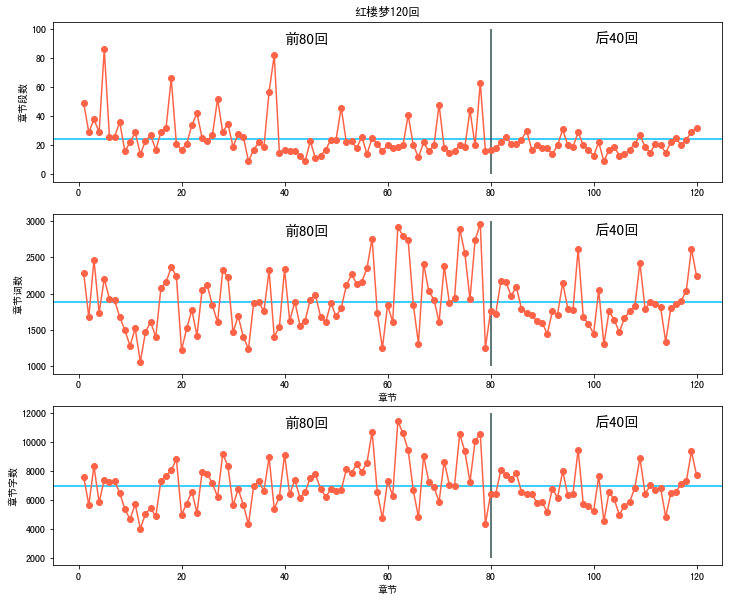

In [10]:
plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.plot(data.chapter_number,data.length_of_chapters,marker="o", linestyle="-",color = "tomato")

plt.ylabel("章节段数")
plt.title("红楼梦120回")
plt.hlines(np.mean(data.length_of_chapters),-5,125,"deepskyblue")
plt.vlines(80,0,100,"darkslategray")
plt.text(40,90,'前80回',fontsize = 15)
plt.text(100,90,'后40回',fontsize = 15)
plt.xlim((-5,125))

plt.subplot(3,1,2)
plt.plot(data.chapter_number,data.length_of_words,marker="o", linestyle="-",color = "tomato")
plt.xlabel("章节")
plt.ylabel("章节词数")
plt.hlines(np.mean(data.length_of_words),-5,125,"deepskyblue")
plt.vlines(80,1000,3000,"darkslategray")
plt.text(40,2800,'前80回',fontsize = 15)
plt.text(100,2800,'后40回',fontsize = 15)
plt.xlim((-5,125))

plt.subplot(3,1,3)
plt.plot(data.chapter_number,data.length_of_characters,marker="o", linestyle="-",color = "tomato")
plt.xlabel("章节")
plt.ylabel("章节字数")
plt.hlines(np.mean(data.length_of_characters),-5,125,"deepskyblue")
plt.vlines(80,2000,12000,"darkslategray")
plt.text(40,11000,'前80回',fontsize = 15)
plt.text(100,11000,'后40回',fontsize = 15)
plt.xlim((-5,125))

plt.show()

+ 蓝色线代表章节平均的段落数和字数，可以看到每一章平均段落数为25左右，平均次数为1900左右，平均字数为7000左右，在60-80回篇幅最多。
+ “红楼梦作者究竟是谁”这个问题引起中国文学界的漫长争论，并持续至今。众多学者认为曹雪芹的原著仅存80回，现存后40回是清人高鄂所续。我们根据灰色线将前80回和后40回进行划分，从这些相互关系可以看出，前80章和后40章还是有一些差异的。

在分词完成后，我们可以统计全书的词频，计算每个词出现的频率并排序。

In [11]:
words = np.concatenate(data.cutted_words)

#统计词频
word_df = pd.DataFrame({"word":words})
word_frequency = word_df.groupby(by=["word"])["word"].agg({"frequency":np.size})
word_frequency = word_frequency.reset_index().sort_values(by="frequency",ascending=False)

word_frequency.head(10)

word  frequency
14635   宝玉       3653
4189    什么       1580
34      一个       1411
35236   贾母       1235
18802   我们       1189
7727    凤姐       1160
37642   那里       1143
33760   袭人       1103
40528   黛玉        996
13714   如今        982

我们通过条形图将出现次数超过500的词语展示出来。

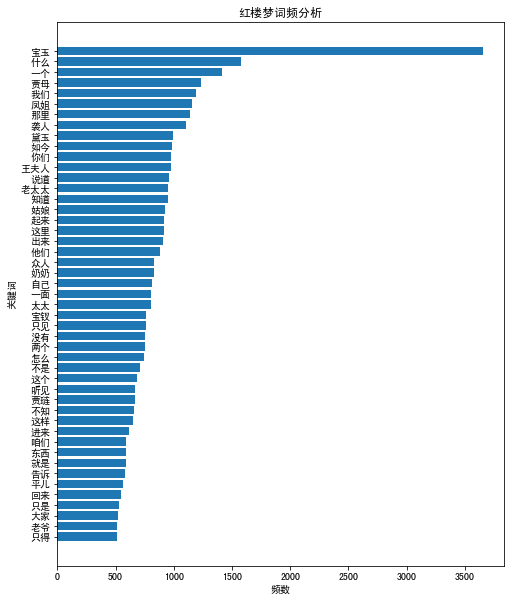

In [12]:
plt.figure(figsize=(8,10))

frequent_words = word_frequency.loc[word_frequency.frequency > 500].sort_values('frequency')
plt.barh(y = frequent_words["word"],width = frequent_words["frequency"])

plt.xticks(size = 10)  
plt.ylabel("关键词")   
plt.xlabel("频数")
plt.title("红楼梦词频分析")
plt.show()

从图中可以看出，宝玉出现的次数最多，是红楼梦中的主角。接下来我们通过Python中的wordcloud库进行词云绘制。

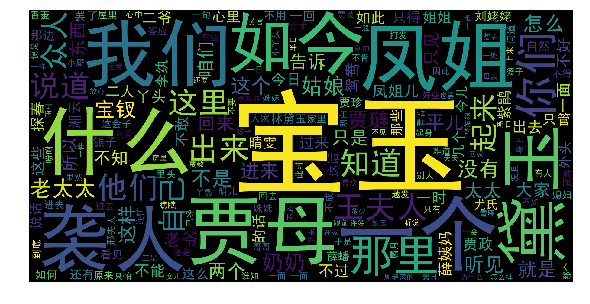

In [13]:
from wordcloud import WordCloud

plt.figure(figsize=(10,5))

wordcloud = WordCloud(font_path='./input/SimHei.ttf',margin=5, width=1800, height=900)

wordcloud.generate("/".join(np.concatenate(data.cutted_words)))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 构建词矩阵
在进行文本聚类之前，我们需要将词进行向量化，这里向量化的方式选用计算TF-IDF矩阵。

+ TF-IDF含义是词频逆文档频率，如果某个词在一篇文章中出现的频率高，并在其他文章中很少出现，则该词的重要性较高。词的重要性随着它在文件中出现的次数成正比增加，但同时会随着它在语料库中出现的频率成反比下降。
+ TfidfVectorizer模型建立后，可通过`fit_transform()`函数进行训练，将文本中的词语转换为词的TF－IDF矩阵；通过`get_feature_names()`可看到所有文本的关键字；通过`vocabulary_`属性查看关键词编号。TfidfVectorizer模型的输出为矩阵形式，通过`toarray()`函数可看到TF－IDF矩阵的结果。

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

content = []
for cutword in data.cutted_words:
    content.append(" ".join(cutword))

## 构建语料库，并计算文档的TF－IDF矩阵
transformer = TfidfVectorizer()
tfidf = transformer.fit_transform(content)

## TF－IDF以稀疏矩阵的形式存储，将TF－IDF转化为数组的形式,文档－词矩阵
word_vectors = tfidf.toarray()
word_vectors

array([[0.        , 0.        , 0.00732401, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0089662 , ..., 0.        , 0.        ,
        0.        ],
       [0.04321373, 0.        , 0.0486704 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00731152, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00886065, ..., 0.        , 0.        ,
        0.        ]])

# 3.红楼梦章节聚类及可视化

K-means聚类：对于给定的样本集A，按照样本之间的距离大小，将样本集A划分为K个簇$A_1,A_2,⋯,A_K$。让这些簇内的点尽量紧密的连在一起，而让簇间的距离尽量的大。

K-Means算法是无监督的聚类算法。目的是使得每个点都属于离它最近的均值（此即聚类中心）对应的簇$A_i$中。这里使用sklearn库中的K-means聚类算法对数据进行聚类分析，得到每一章所属的簇。

参数聚类数目`n_clusters = 3`，随机种子`random_state = 0`。

In [15]:
from sklearn.cluster import KMeans

## 对word_vectors进行k均值聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(word_vectors)

## 聚类得到的类别
kmean_labels = data[["chapter_name","chapter"]]
kmean_labels["cluster"] = kmeans.labels_
kmean_labels

chapter_name chapter  cluster
0    甄士隐梦幻识通灵,贾雨村风尘怀闺秀     第一回        0
1    贾夫人仙逝扬州城,冷子兴演说荣国府     第二回        0
2    贾雨村夤缘复旧职,林黛玉抛父进京都     第三回        1
3    薄命女偏逢薄命郎,葫芦僧乱判葫芦案     第四回        2
4    游幻境指迷十二钗,饮仙醪曲演红楼梦     第五回        1
5    贾宝玉初试云雨情,刘姥姥一进荣国府     第六回        0
6    送宫花贾琏戏熙凤,宴宁府宝玉会秦钟     第七回        0
7    比通灵金莺微露意,探宝钗黛玉半含酸     第八回        1
8    恋风流情友入家塾,起嫌疑顽童闹学堂     第九回        1
9    金寡妇贪利权受辱,张太医论病细穷源     第十回        0
10   庆寿辰宁府排家宴,见熙凤贾瑞起淫心    第十一回        0
11   王熙凤毒设相思局,贾天祥正照风月鉴    第十二回        0
12   秦可卿死封龙禁尉,王熙凤协理宁国府    第十三回        0
13   林如海捐馆扬州城,贾宝玉路谒北静王    第十四回        0
14   王凤姐弄权铁槛寺,秦鲸卿得趣馒头庵    第十五回        1
15   贾元春才选凤藻宫,秦鲸卿夭逝黄泉路    第十六回        0
16   大观园试才题对额,荣国府归省庆元宵    第十七回        1
17   隔珠帘父女勉忠勤,搦湘管姊弟裁题咏    第十八回        1
18   情切切良宵花解语,意绵绵静日玉生香    第十九回        1
19   王熙凤正言弹妒意,林黛玉俏语谑娇音    第二十回        1
20   贤袭人娇嗔箴宝玉,俏平儿软语救贾琏   第二十一回        1
21   听曲文宝玉悟禅机,制灯迷贾政悲谶语   第二十二回        1
22   西厢记妙词通戏语,牡丹亭艳曲警芳心   第二十三回        1
23   醉金刚轻财尚义侠,痴女儿遗帕惹相思   第二十四回        1
24   魇魔法姊弟逢五鬼,红楼梦通灵遇双真   第二十五回        1
25   蜂腰桥设言传心事,潇湘馆春困发幽情   第二十六回        1
26   滴翠亭杨妃戏彩蝶,埋香冢飞燕泣残红   第二十七回        1
27   蒋玉菡情赠茜香罗,薛宝钗羞笼红麝串   第二十八回        1
28   享福人福深还祷福,痴情女情重愈斟情   第二十九回        1
29   宝钗借扇机带双敲,龄官划蔷痴及局外    第三十回        1
30   撕扇子作千金一笑,因麒麟伏白首双星   第三十一回        1
31   诉肺腑心迷活宝玉,含耻辱情烈死金钏   第三十二回        1
32   手足耽耽小动唇舌,不肖种种大承笞挞   第三十三回        1
33   情中情因情感妹妹,错里错以错劝哥哥   第三十四回        1
34   白玉钏亲尝莲叶羹,黄金莺巧结梅花络   第三十五回        1
35   绣鸳鸯梦兆绛芸轩,识分定情悟梨香院   第三十六回        1
36   秋爽斋偶结海棠社,蘅芜苑夜拟菊花题   第三十七回        1
37   林潇湘魁夺菊花诗,薛蘅芜讽和螃蟹咏   第三十八回        0
38   村姥姥是信口开合,情哥哥偏寻根究底   第三十九回        0
39   史太君两宴大观园,金鸳鸯三宣牙牌令    第四十回        0
40   栊翠庵茶品梅花雪,怡红院劫遇母蝗虫   第四十一回        0
41   蘅芜君兰言解疑癖,潇湘子雅谑补余香   第四十二回        0
42   闲取乐偶攒金庆寿,不了情暂撮土为香   第四十三回        1
43   变生不测凤姐泼醋,喜出望外平儿理妆   第四十四回        0
44   金兰契互剖金兰语,风雨夕闷制风雨词   第四十五回        1
45   尴尬人难免尴尬事,鸳鸯女誓绝鸳鸯偶   第四十六回        0
46   呆霸王调情遭苦打,冷郎君惧祸走他乡   第四十七回        2
47   滥情人情误思游艺,慕雅女雅集苦吟诗   第四十八回        2
48   琉璃世界白雪红梅,脂粉香娃割腥啖膻   第四十九回        1
49   芦雪庵争联即景诗,暖香坞雅制春灯谜    第五十回        1
50   薛小妹新编怀古诗,胡庸医乱用虎狼药   第五十一回        1
51   俏平儿情掩虾须镯,勇晴雯病补雀金裘   第五十二回        1
52   宁国府除夕祭宗祠,荣国府元宵开夜宴   第五十三回        0
53   史太君破陈腐旧套,王熙凤效戏彩斑衣   第五十四回        1
54   辱亲女愚妾争闲气,欺幼主刁奴蓄险心   第五十五回        0
55   敏探春兴利除宿弊,时宝钗小惠全大体   第五十六回        1
56   慧紫鹃情辞试忙玉,慈姨妈爱语慰痴颦   第五十七回        1
57   杏子阴假凤泣虚凰,茜纱窗真情揆痴理   第五十八回        1
58   柳叶渚边嗔莺咤燕,绛云轩里召将飞符   第五十九回        0
59   茉莉粉替去蔷薇硝,玫瑰露引来茯苓霜    第六十回        1
60   投鼠忌器宝玉瞒赃,判冤决狱平儿行权   第六十一回        0
61   憨湘云醉眠芍药茵,呆香菱情解石榴裙   第六十二回        1
62   寿怡红群芳开夜宴,死金丹独艳理亲丧   第六十三回        1
63   幽淑女悲题五美吟,浪荡子情遗九龙佩   第六十四回        0
64   贾二舍偷娶尤二姨,尤三姐思嫁柳二郎   第六十五回        0
65   情小妹耻情归地府,冷二郎一冷入空门   第六十六回        0
66   见土仪颦卿思故里,闻秘事凤姐讯家童   第六十七回        0
67   苦尤娘赚入大观园,酸凤姐大闹宁国府   第六十八回        0
68   弄小巧用借剑杀人,觉大限吞生金自逝   第六十九回        0
69   林黛玉重建桃花社,史湘云偶填柳絮词    第七十回        1
70   嫌隙人有心生嫌隙,鸳鸯女无意遇鸳鸯   第七十一回        0
71   王熙凤恃强羞说病,来旺妇倚势霸成亲   第七十二回        0
72   痴丫头误拾绣春囊,懦小姐不问累金凤   第七十三回        0
73   惑奸谗抄检大观园,矢孤介杜绝宁国府   第七十四回        0
74   开夜宴异兆发悲音,赏中秋新词得佳谶   第七十五回        0
75   凸碧堂品笛感凄清,凹晶馆联诗悲寂寞   第七十六回        0
76   俏丫鬟抱屈夭风流,美优伶斩情归水月   第七十七回        1
77   老学士闲征诡画词,痴公子杜撰芙蓉诔   第七十八回        1
78   薛文龙悔娶河东狮,贾迎春误嫁中山狼   第七十九回        2
79   美香菱屈受贪夫棒,王道士胡诌妒妇方    第八十回        2
80   占旺相四美钓游鱼,奉严词两番入家塾   第八十一回        1
81   老学究讲义警顽心,病潇湘痴魂惊恶梦   第八十二回        1
82   省宫闱贾元妃染恙,闹闺阃薛宝钗吞声   第八十三回        0
83   试文字宝玉始提亲,探惊风贾环重结怨   第八十四回        0
84   贾存周报升郎中任,薛文起复惹放流刑   第八十五回        1
85   受私贿老官翻案牍,寄闲情淑女解琴书   第八十六回        1
86   感深秋抚琴悲往事,坐禅寂走火入邪魔   第八十七回        1
87   博庭欢宝玉赞孤儿,正家法贾珍鞭悍仆   第八十八回        0
88   人亡物在公子填词,蛇影杯弓颦卿绝粒   第八十九回        1
89   失绵衣贫女耐嗷嘈,送果品小郎惊叵测    第九十回        0
90   纵淫心宝蟾工设计,布疑阵宝玉妄谈禅   第九十一回        2
91   评女传巧姐慕贤良,玩母珠贾政参聚散   第九十二回        0
92   甄家仆投靠贾家门,水月庵掀翻风月案   第九十三回        0
93   宴海棠贾母赏花妖,失宝玉通灵知奇祸   第九十四回        1
94   因讹成实元妃薨逝,以假混真宝玉疯颠   第九十五回        1
95   瞒消息凤姐设奇谋,泄机关颦儿迷本性   第九十六回        1
96   林黛玉焚稿断痴情,薛宝钗出闺成大礼   第九十七回        1
97   苦绛珠魂归离恨天,病神瑛泪洒相思地   第九十八回        1
98   守官箴恶奴同破例,阅邸报老舅自担惊   第九十九回        1
99   破好事香菱

In [16]:
## 查看每个簇有多少章节
count = kmean_labels.groupby("cluster")['chapter'].count()
count

cluster
0    50
1    62
2     8
Name: chapter, dtype: int64

我们通过设置簇的个数为3，可以大致衡量哪些章节的文字内容较为接近，如簇编号为2的章节有第4、79、80、91、103回等，说明这些章节的文本内容距离较近。接下来使用降维技术将TF-IDF矩阵降维，并将K-means聚类的簇对比降维数据进行可视化。

多维标度（Multidimensional scaling，缩写MDS，又译“多维尺度”）也称作“相似度结构分析”（Similarity structure analysis），属于多重变量分析的方法之一，是社会学、数量心理学、市场营销等统计实证分析的常用方法。MDS在降低数据维度的时候尽可能的保留样本之间的相对距离。

In [17]:
from sklearn.manifold import MDS

## 使用MDS对数据进行降维
mds = MDS(n_components=2,random_state=12)
mds_results = mds.fit_transform(word_vectors)
mds_results.shape

(120, 2)

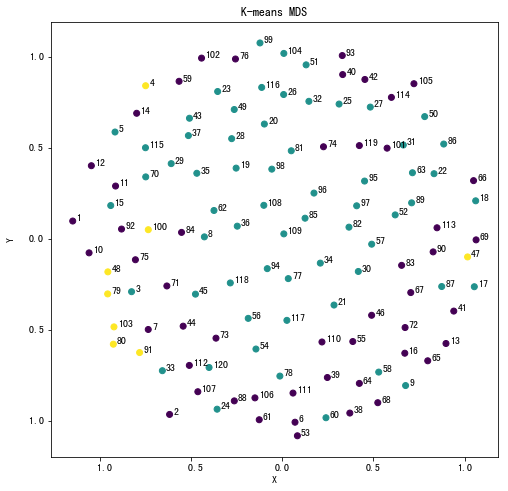

In [18]:
## 绘制降维后的结果
plt.figure(figsize=(8,8))
plt.scatter(mds_results[:,0],mds_results[:,1],c = kmean_labels.cluster)

for i in (np.arange(120)):
    plt.text(mds_results[i,0]+0.02,mds_results[i,1],s = data.chapter_number[i])
    
plt.xlabel("X")   
plt.ylabel("Y") 
plt.title("K-means MDS")
plt.show()

使用MDS将各章的词向量降至2维后，将K-means聚类的簇对比降维数据进行可视化，可以大致验证聚类结果的有效性。如簇0(紫色点)和簇2(黄色)分别展示在图的四周，簇1(绿色)的章节主要分布在图的中间，每个簇之间的章节相对距离较小。

PCA降维是一种常见的数据降维方法，其目的是在“信息”损失较小的前提下，将高维的数据转换到低维，从而减小计算量。PCA通常用于高维数据集的探索与可视化，还可以用于数据压缩，数据预处理等。

In [19]:
from sklearn.decomposition import PCA

## 使用PCA对数据进行降维
pca = PCA(n_components=2)

pca.fit(word_vectors)
print(pca.explained_variance_ratio_)

## 对数据降维
pca_results = pca.fit_transform(word_vectors)
print(pca_results.shape)

[0.03700399 0.02803801]
(120, 2)


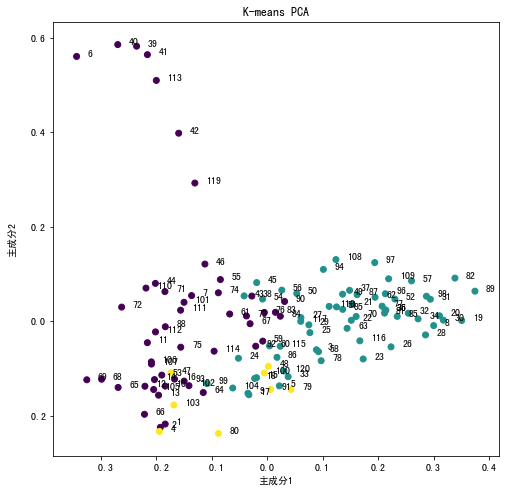

In [20]:
## 绘制降维后的结果
plt.figure(figsize=(8,8))
plt.scatter(pca_results[:,0],pca_results[:,1],c = kmean_labels.cluster)

for i in np.arange(120):
    plt.text(pca_results[i,0]+0.02,pca_results[i,1],s = data.chapter_number[i])
    
plt.xlabel("主成分1")   
plt.ylabel("主成分2")  
plt.title("K-means PCA")  
plt.show() 

使用PCA将各章的词向量降至2维后，将K-means聚类的簇对比降维数据进行可视化，可以得出相似的结论。簇2(黄色)的两个主成分相对较小，分布在图的左下部分较多，簇1(绿色)主成分相对较大，分布靠右，验证了聚类结果的有效性。

上面已经成功地使用K-means对文档进行聚类和绘图，现在可以试一下另外一种聚类算法。Ward聚类属于凝聚聚类算法，即每个处理阶段，将距离最小的两个对象分到一个类中。我使用预先计算的余弦距离矩阵计算出距离矩阵，然后将其绘制成树状图。


层次聚类(Hierarchical Clustering)是聚类算法的一种，通过计算不同类别数据点间的相似度来创建一棵有层次的嵌套聚类树。在聚类树中，不同类别的原始数据点是树的最低层，树的顶层是一个聚类的根节点。

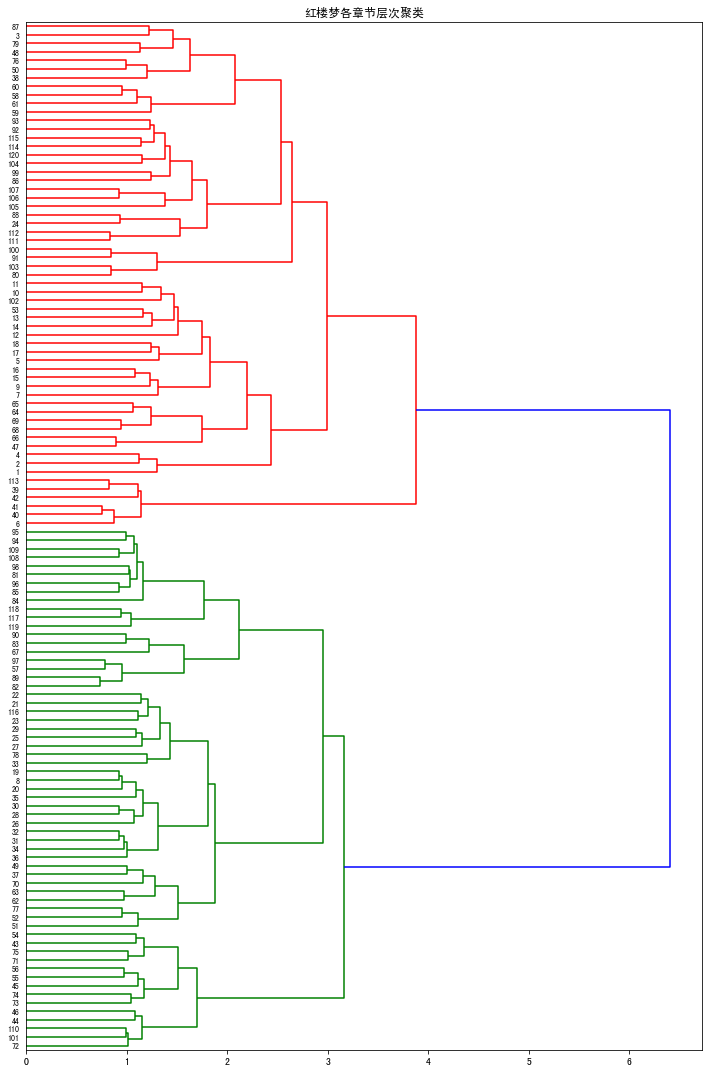

In [21]:
from scipy.cluster.hierarchy import dendrogram,ward
from scipy.spatial.distance import pdist,squareform

## 标签，每个章节的标题
labels = data.chapter_number.values

#计算每章的距离矩阵
cos_distance_matrix = squareform(pdist(word_vectors,'cosine'))

## 根据距离聚类
ward_results = ward(cos_distance_matrix)  

## 聚类结果可视化
fig, ax = plt.subplots(figsize=(10, 15))

ax = dendrogram(ward_results,orientation='right', labels=labels);
plt.yticks(size = 8)
plt.title("红楼梦各章节层次聚类")

plt.tight_layout()
plt.show()   

层次聚类可以清晰地表示章节之间的层次关系，章节和距离最近的章节进行合并，不断递归形成树。从层次聚类树形图中我们可以看出《红楼梦》哪些回最为接近，如115回和116回的距离最为接近，117回和118回的距离最为接近等等...

# 4.总结

在本案例中，我们首先对红楼梦120回的文本数据进行了清洗和格式的整理；接着宏观了分析了其中的章节结构、次数和字数等基本情况；然后通过分词、分析词频并通过可视化的方法进行展示；最后通过两种聚类方法对各章节的文本进行聚类，使用两种降维方式对聚类结果进行验证和可视化。《红楼梦》被评为中国古典章回小说的巅峰之作，思想价值和艺术价值极高。关于红楼梦的研究一直是中国传统文学的热点，红学家们众说纷纭，思想观点百花齐放，在此案例中我们从统计分析和文本挖掘等角度对红楼梦进行了一些简单的分析。此外关于小说中人物的社交关系也是一大热点，在下一个案例中我们尝试通过图与网络结构对红楼梦中的人物关系进行分析。